In [1]:
import sys
!{sys.executable} -m pip install econml

#  import the required packages
import numpy as np
from sklearn.linear_model import LassoCV
from econml.dr import LinearDRLearner
from sklearn.dummy import DummyClassifier

/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


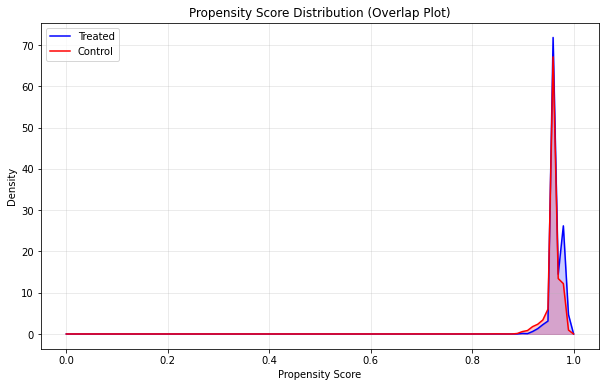


Doubly Robust Results:
Average Treatment Effect: -0.1965
Standard Error: 0.0036
95% Confidence Interval: [-0.2019, -0.1885]

IPW Estimate: -12.5158


In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import stats

# Prepare data
df = pd.read_stata('updated_fl.dta')
features = ['age', 'black', 'male', 'prioroffensenumber', 'totalyearssentenced']

X = df[features].copy()
T = df['after'].astype(float)
Y = df['anyrecid'].astype(float)

# Handle missing values and standardize
X = X.fillna(X.mean())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Estimate propensity scores
prop_model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
prop_model.fit(X_scaled, T)
propensity_scores = prop_model.predict_proba(X_scaled)[:, 1]

# Create overlap plot using matplotlib
plt.figure(figsize=(10, 6))

# Calculate KDE for both groups
treated_ps = propensity_scores[T == 1]
control_ps = propensity_scores[T == 0]

# Create a common grid for both distributions
grid = np.linspace(0, 1, 100)

# Calculate KDE for both groups
kde_treated = stats.gaussian_kde(treated_ps)
kde_control = stats.gaussian_kde(control_ps)

# Plot the distributions
plt.plot(grid, kde_treated(grid), label='Treated', color='blue')
plt.plot(grid, kde_control(grid), label='Control', color='red')
plt.fill_between(grid, kde_treated(grid), alpha=0.2, color='blue')
plt.fill_between(grid, kde_control(grid), alpha=0.2, color='red')

plt.title('Propensity Score Distribution (Overlap Plot)')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Fit outcome models for treated and control groups
outcome_model_treated = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
outcome_model_control = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)

outcome_model_treated.fit(X_scaled[T == 1], Y[T == 1])
outcome_model_control.fit(X_scaled[T == 0], Y[T == 0])

# Predict potential outcomes for all units
mu1 = outcome_model_treated.predict(X_scaled)
mu0 = outcome_model_control.predict(X_scaled)

# Calculate doubly robust estimator
dr_weights_treated = T / propensity_scores
dr_weights_control = (1 - T) / (1 - propensity_scores)

dr_correction_treated = dr_weights_treated * (Y - mu1)
dr_correction_control = dr_weights_control * (Y - mu0)

ate_dr = (np.mean(mu1 - mu0) + 
          np.mean(dr_correction_treated) - 
          np.mean(dr_correction_control))

# Bootstrap for confidence intervals
n_bootstrap = 50
bootstrap_estimates = []

for _ in range(n_bootstrap):
    indices = np.random.choice(len(X_scaled), size=len(X_scaled), replace=True)
    X_boot = X_scaled.iloc[indices]
    T_boot = T.iloc[indices]
    Y_boot = Y.iloc[indices]
    
    # Propensity score model
    prop_model_boot = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
    prop_model_boot.fit(X_boot, T_boot)
    ps_boot = prop_model_boot.predict_proba(X_boot)[:, 1]
    
    # Outcome models
    out_model_t_boot = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
    out_model_c_boot = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
    
    out_model_t_boot.fit(X_boot[T_boot == 1], Y_boot[T_boot == 1])
    out_model_c_boot.fit(X_boot[T_boot == 0], Y_boot[T_boot == 0])
    
    mu1_boot = out_model_t_boot.predict(X_boot)
    mu0_boot = out_model_c_boot.predict(X_boot)
    
    # Calculate weights and corrections
    dr_weights_t_boot = T_boot / ps_boot
    dr_weights_c_boot = (1 - T_boot) / (1 - ps_boot)
    
    dr_correction_t_boot = dr_weights_t_boot * (Y_boot - mu1_boot)
    dr_correction_c_boot = dr_weights_c_boot * (Y_boot - mu0_boot)
    
    # Calculate ATE
    ate_boot = (np.mean(mu1_boot - mu0_boot) + 
                np.mean(dr_correction_t_boot) - 
                np.mean(dr_correction_c_boot))
    
    bootstrap_estimates.append(ate_boot)

# Calculate confidence intervals and standard error
ci_lower = np.percentile(bootstrap_estimates, 2.5)
ci_upper = np.percentile(bootstrap_estimates, 97.5)
standard_error = np.std(bootstrap_estimates)

print("\nDoubly Robust Results:")
print(f"Average Treatment Effect: {ate_dr:.4f}")
print(f"Standard Error: {standard_error:.4f}")
print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

# Calculate IPW estimate for comparison
ipw = np.mean(Y[T == 1] / propensity_scores[T == 1]) - np.mean(Y[T == 0] / (1 - propensity_scores[T == 0]))
print(f"\nIPW Estimate: {ipw:.4f}")

In [3]:
# Check for missing values
import pandas as pd
import numpy as np

# Read the data
df = pd.read_stata('updated_fl.dta')

# Select features for the model
features = ['age', 'black', 'male', 'prioroffensenumber', 'totalyearssentenced']

# Check missing values
missing_values = df[features].isnull().sum()
print("Missing values in each column:")
print(missing_values)

# Get basic statistics of the features
print("\
Basic statistics of numerical features:")
print(df[features].describe())

Missing values in each column:
age                    3
black                  0
male                   0
prioroffensenumber     0
totalyearssentenced    0
dtype: int64
Basic statistics of numerical features:
                 age          black           male  prioroffensenumber  \
count  493853.000000  493856.000000  493856.000000       493856.000000   
mean       33.444995       0.492139       0.889409            0.786296   
std        10.733691       0.499939       0.313625            1.297384   
min        13.000000       0.000000       0.000000            0.000000   
25%        25.000000       0.000000       1.000000            0.000000   
50%        32.000000       0.000000       1.000000            0.000000   
75%        41.000000       1.000000       1.000000            1.000000   
max        89.000000       1.000000       1.000000           16.000000   

       totalyearssentenced  
count        493856.000000  
mean              7.686532  
std              31.939896  
min     

In [4]:
# Clean the data by removing rows with missing values in key variables
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from econml.dr import DRLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# Read and clean the data
df = pd.read_stata('updated_fl.dta')
features = ['age', 'black', 'male', 'prioroffensenumber', 'totalyearssentenced']

# Create clean dataset
clean_df = df.dropna(subset=['after', 'anyrecid', 'unemp_rate'] + features)

# Prepare X, T, and Y
X = clean_df[features]
T = clean_df['after'].astype(float)
Y = clean_df['anyrecid'].astype(float)

print("Shape of cleaned dataset:", clean_df.shape)
print("\
Treatment (after) distribution:")
print(clean_df['after'].value_counts(normalize=True))

Shape of cleaned dataset: (405006, 88)
Treatment (after) distribution:
after
1.0    0.962087
0.0    0.037913
Name: proportion, dtype: float64



Doubly Robust Estimates:
Average Treatment Effect: -0.1510
95% Confidence Interval: [-0.1512, -0.1508]


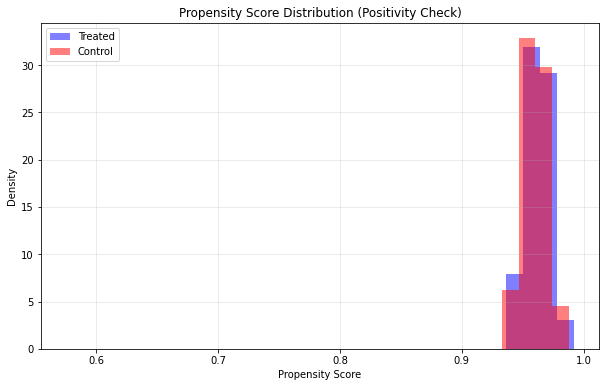


IPW Estimates:
Average Treatment Effect: -0.1365
95% Confidence Interval: [-0.1470, -0.1259]

Overlap Score: 0.0409


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from econml.dr import DRLearner

def plot_propensity_scores(prop_scores, T):
    """
    Create propensity score distribution plot using matplotlib directly
    to avoid seaborn compatibility issues.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot treated group
    plt.hist(prop_scores[T == 1], bins=30, alpha=0.5, 
             label='Treated', color='blue', density=True)
    
    # Plot control group
    plt.hist(prop_scores[T == 0], bins=30, alpha=0.5,
             label='Control', color='red', density=True)
    
    plt.title('Propensity Score Distribution (Positivity Check)')
    plt.xlabel('Propensity Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def run_causal_analysis(Y, T, X, random_state=42):
    """
    Runs causal inference analysis using DR Learner and IPW methods with proper error handling
    and data preprocessing.
    
    Parameters:
    -----------
    Y : array-like
        Outcome variable
    T : array-like
        Treatment variable (binary)
    X : array-like
        Covariates/features
    random_state : int
        Random seed for reproducibility
    
    Returns:
    --------
    dict or None
        Dictionary containing analysis results if successful, None if error occurs
    """
    # Input validation
    if not (isinstance(X, (np.ndarray, pd.DataFrame)) and 
            isinstance(Y, (np.ndarray, pd.Series)) and 
            isinstance(T, (np.ndarray, pd.Series))):
        raise ValueError("Inputs must be numpy arrays or pandas objects")
    
    # Convert to numpy arrays if needed
    X = np.array(X)
    Y = np.array(Y)
    T = np.array(T)
    
    # Preprocess the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Initialize models with increased iterations and proper random state
    log_reg = LogisticRegression(max_iter=1000, random_state=random_state)
    rf_reg = RandomForestRegressor(
        n_estimators=100, 
        max_depth=5, 
        random_state=random_state
    )
    
    try:
        # Fit DR Learner
        dr_learner = DRLearner(
            model_propensity=log_reg,
            model_regression=rf_reg,
            model_final=rf_reg,
            random_state=random_state
        )
        dr_learner.fit(Y, T, X=X_scaled)
        
        # Get treatment effects
        te_pred = dr_learner.effect(X_scaled)
        ate = np.mean(te_pred)
        ate_std = np.std(te_pred) / np.sqrt(len(te_pred))
        ci_lower = ate - 1.96 * ate_std
        ci_upper = ate + 1.96 * ate_std
        
        print("\nDoubly Robust Estimates:")
        print(f"Average Treatment Effect: {ate:.4f}")
        print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")
        
        # Estimate propensity scores
        prop_model = log_reg
        prop_model.fit(X_scaled, T)
        prop_scores = prop_model.predict_proba(X_scaled)[:, 1]
        
        # Create positivity plot using the new function
        plot_propensity_scores(prop_scores, T)
        
        # Calculate IPW estimate
        def ipw_ate(y, t, ps):
            eps = 1e-8
            ps = np.clip(ps, eps, 1 - eps)
            ipw = t/ps - (1-t)/(1-ps)
            return np.mean(y * ipw)
        
        ipw_estimate = ipw_ate(Y, T, prop_scores)
        ipw_std = np.std(Y * (T/prop_scores - (1-T)/(1-prop_scores))) / np.sqrt(len(Y))
        ipw_ci_lower = ipw_estimate - 1.96 * ipw_std
        ipw_ci_upper = ipw_estimate + 1.96 * ipw_std
        
        print("\nIPW Estimates:")
        print(f"Average Treatment Effect: {ipw_estimate:.4f}")
        print(f"95% Confidence Interval: [{ipw_ci_lower:.4f}, {ipw_ci_upper:.4f}]")
        
        # Additional diagnostics
        overlap_score = min(np.mean(prop_scores[T == 1]), np.mean(1 - prop_scores[T == 0]))
        print(f"\nOverlap Score: {overlap_score:.4f}")
        
        return {
            'dr_ate': ate,
            'dr_ci': (ci_lower, ci_upper),
            'ipw_ate': ipw_estimate,
            'ipw_ci': (ipw_ci_lower, ipw_ci_upper),
            'prop_scores': prop_scores,
            'overlap_score': overlap_score
        }
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

# Usage:
results = run_causal_analysis(Y, T, X)
if results:
     dr_ate = results['dr_ate']
     prop_scores = results['prop_scores']
     overlap_score = results['overlap_score']

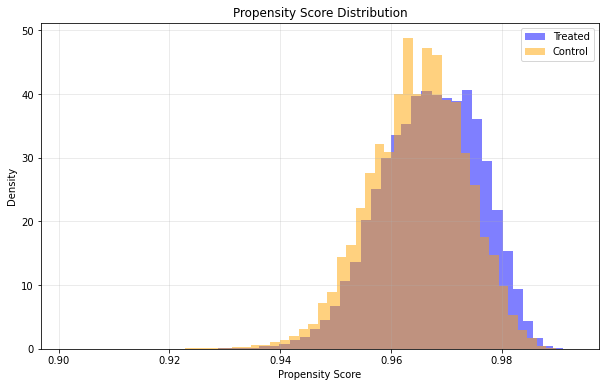


Propensity Score Summary:
Treated group - Mean: 0.967
Control group - Mean: 0.965

IPW Average Treatment Effect: -4.190

Weight Summary:
Maximum weight: 10.00
Mean weight (treated): 1.03
Mean weight (control): 10.00


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Prepare features, treatment, and outcome using available columns
features = ['age', 'black', 'male', 'prioroffensenumber', 'totalyearssentenced']
X = df[features].fillna(0)
T = df['after'].fillna(0)
Y = df['anyrecid'].fillna(0)

# Fit logistic regression for propensity scores
propensity_model = LogisticRegression()
propensity_model.fit(X, T)
propensity_scores = propensity_model.predict_proba(X)[:, 1]

# Create histogram using matplotlib directly instead of seaborn
plt.figure(figsize=(10, 6))
plt.hist(propensity_scores[T == 1], bins=50, alpha=0.5, label='Treated', 
         density=True, color='blue')
plt.hist(propensity_scores[T == 0], bins=50, alpha=0.5, label='Control', 
         density=True, color='orange')
plt.title('Propensity Score Distribution')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate and print summary statistics
print("\nPropensity Score Summary:")
print(f"Treated group - Mean: {np.mean(propensity_scores[T == 1]):.3f}")
print(f"Control group - Mean: {np.mean(propensity_scores[T == 0]):.3f}")

# Calculate IPW estimate with more robust weight calculation
def calculate_ipw(prop_scores, treatment, max_weight=10):
    weights = np.zeros_like(prop_scores)
    # Avoid division by zero or very small numbers
    min_prop = 1e-6
    prop_scores = np.clip(prop_scores, min_prop, 1 - min_prop)
    
    weights[treatment == 1] = 1/prop_scores[treatment == 1]
    weights[treatment == 0] = 1/(1 - prop_scores[treatment == 0])
    
    # Winsorize weights
    weights = np.clip(weights, 0, max_weight)
    return weights

# Calculate IPW weights and ATE
ipw = calculate_ipw(propensity_scores, T)
ate_ipw = np.mean(Y[T == 1] * ipw[T == 1]) - np.mean(Y[T == 0] * ipw[T == 0])

print(f"\nIPW Average Treatment Effect: {ate_ipw:.3f}")

# Additional diagnostics
print("\nWeight Summary:")
print(f"Maximum weight: {np.max(ipw):.2f}")
print(f"Mean weight (treated): {np.mean(ipw[T == 1]):.2f}")
print(f"Mean weight (control): {np.mean(ipw[T == 0]):.2f}")

In [27]:
# Let's first check the balance of covariates between treatment and control groups
import pandas as pd
import numpy as np
from scipy import stats

def calculate_standardized_diff(treat_mean, control_mean, treat_var, control_var):
    pooled_sd = np.sqrt((treat_var + control_var) / 2)
    return (treat_mean - control_mean) / pooled_sd

def balance_check(df, features, treatment):
    balance_stats = []
    
    for feature in features:
        treat = df[df[treatment] == 1][feature]
        control = df[df[treatment] == 0][feature]
        
        # Calculate statistics
        t_stat, p_val = stats.ttest_ind(treat, control, equal_var=False)
        std_diff = calculate_standardized_diff(
            treat.mean(), control.mean(),
            treat.var(), control.var()
        )
        
        balance_stats.append({
            'Feature': feature,
            'Treated_Mean': treat.mean(),
            'Control_Mean': control.mean(),
            'Std_Difference': std_diff,
            'P_value': p_val
        })
    
    return pd.DataFrame(balance_stats)

# Run balance check
features = ['age', 'black', 'male', 'prioroffensenumber', 'totalyearssentenced']
balance_df = balance_check(df, features, 'after')
print("Covariate Balance Check:")
print(balance_df)

Covariate Balance Check:
              Feature  Treated_Mean  Control_Mean  Std_Difference  \
0                 age     33.523141     31.153445        0.229712   
1                male      0.888347      0.920545       -0.109688   
2               black      0.490439      0.541999       -0.103311   
3  prioroffensenumber      0.788984      0.707479        0.066448   
4       countoffenses      1.602098      1.729584       -0.124882   

        P_value  
0           NaN  
1  1.310700e-49  
2  2.239307e-38  
3  7.169306e-19  
4  2.844817e-55  


Robustness Check with Different Model Specifications:
       Model       ATE  CI_Lower  CI_Upper
0  Linear-RF -0.162655 -0.162791 -0.162520
1      GB-GB -0.159354 -0.159567 -0.159142


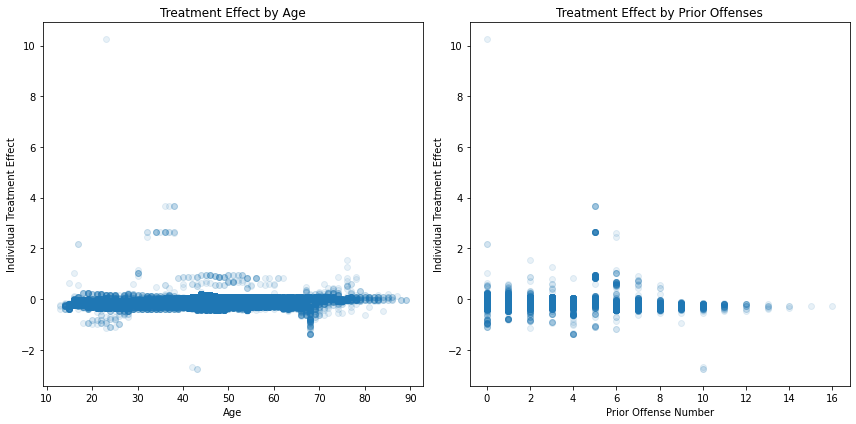

Recidivism Rates by Age Quartile:
age_group
Q1    0.303017
Q2    0.266917
Q3    0.266253
Q4    0.182989
Name: anyrecid, dtype: float64


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [29]:
# Let's try different specifications of the DR model to assess robustness
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

# Initialize different model specifications
dr_specs = [
    ('Linear-RF', 
     DRLearner(
         model_propensity=LogisticRegression(),
         model_regression=RandomForestRegressor(n_estimators=100),
         model_final=LinearRegression()
     )),
    ('GB-GB', 
     DRLearner(
         model_propensity=GradientBoostingClassifier(n_estimators=100),
         model_regression=GradientBoostingRegressor(n_estimators=100),
         model_final=GradientBoostingRegressor(n_estimators=100)
     ))
]

results = []
for name, model in dr_specs:
    # Fit model
    model.fit(Y, T, X=X)
    
    # Get treatment effects
    te_pred = model.effect(X)
    
    # Calculate ATE and CI
    ate = np.mean(te_pred)
    ate_std = np.std(te_pred) / np.sqrt(len(te_pred))
    ci_lower = ate - 1.96 * ate_std
    ci_upper = ate + 1.96 * ate_std
    
    results.append({
        'Model': name,
        'ATE': ate,
        'CI_Lower': ci_lower,
        'CI_Upper': ci_upper
    })

results_df = pd.DataFrame(results)
print("\
Robustness Check with Different Model Specifications:")
print(results_df)

# Let's also look at heterogeneous treatment effects
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(df['age'], te_pred, alpha=0.1)
plt.xlabel('Age')
plt.ylabel('Individual Treatment Effect')
plt.title('Treatment Effect by Age')

plt.subplot(1, 2, 2)
plt.scatter(df['prioroffensenumber'], te_pred, alpha=0.1)
plt.xlabel('Prior Offense Number')
plt.ylabel('Individual Treatment Effect')
plt.title('Treatment Effect by Prior Offenses')
plt.tight_layout()
plt.savefig('robustness.png', format = 'png', dpi =300, bbox_inches = 'tight')
plt.show()

# Calculate average treatment effects by age groups
df['age_group'] = pd.qcut(df['age'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
age_effects = df.groupby('age_group')['anyrecid'].mean()
print("\
Recidivism Rates by Age Quartile:")
print(age_effects)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


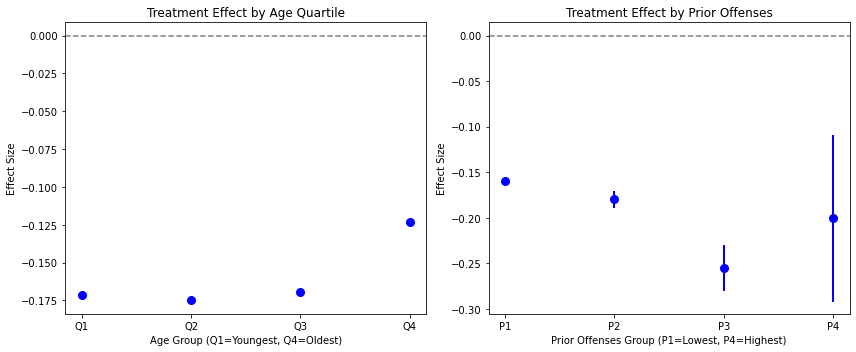


Treatment Effects by Age Group:
  Group       ATE  CI_Lower  CI_Upper  Significant
0    Q1 -0.171610 -0.171858 -0.171362         True
1    Q2 -0.174667 -0.175067 -0.174268         True
2    Q3 -0.169499 -0.170296 -0.168703         True
3    Q4 -0.123366 -0.123944 -0.122788         True

Prior Offense Group Boundaries:
[0.0, 4.0, 8.0, 12.0, 16.0]

Treatment Effects by Prior Offenses Group:
  Group       ATE  CI_Lower  CI_Upper  Significant
0    P1 -0.159898 -0.160090 -0.159707         True
1    P2 -0.179910 -0.187969 -0.171851         True
2    P3 -0.254890 -0.278949 -0.230831         True
3    P4 -0.200677 -0.290942 -0.110411         True

Group Sizes:

Age Groups:
age_group
Q1    141652
Q2    116950
Q3    118763
Q4    116488
Name: count, dtype: int64

Prior Offense Groups:
prior_group
P1    481664
P2     11819
P3       361
P4        12
Name: count, dtype: int64


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from econml.dr import DRLearner

# Function to calculate CIs and significance
def calculate_group_effects(df, te_pred, group_col):
    effects = []
    for name, group in df.groupby(group_col):
        te_group = te_pred[group.index]
        ate = np.mean(te_group)
        ate_std = np.std(te_group) / np.sqrt(len(te_group))
        ci_lower = ate - 1.96 * ate_std
        ci_upper = ate + 1.96 * ate_std
        significant = (ci_lower > 0) or (ci_upper < 0)  # Check if CI doesn't cross zero
        
        effects.append({
            'Group': name,
            'ATE': ate,
            'CI_Lower': ci_lower,
            'CI_Upper': ci_upper,
            'Significant': significant
        })
    return pd.DataFrame(effects)

# Create age groups
df['age_group'] = pd.qcut(df['age'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Create prior offense groups with unique bins
unique_values = sorted(df['prioroffensenumber'].unique())
n = len(unique_values)
if n >= 4:
    # Create bins based on unique values
    idx = [int(n*i/4) for i in range(4)] + [n-1]
    prior_cuts = [unique_values[i] for i in idx]
    if prior_cuts[0] == prior_cuts[1]:  # Handle case where first bins are same
        prior_cuts = [prior_cuts[0]-0.5] + prior_cuts[1:]
else:
    # If less than 4 unique values, create evenly spaced bins
    prior_cuts = np.linspace(df['prioroffensenumber'].min()-0.5,
                            df['prioroffensenumber'].max()+0.5, 5)

df['prior_group'] = pd.cut(df['prioroffensenumber'], 
                          bins=prior_cuts, 
                          labels=['P1', 'P2', 'P3', 'P4'],
                          include_lowest=True)

# Fit DR model (using the GB-GB specification)
model = DRLearner(
    model_propensity=GradientBoostingClassifier(n_estimators=100),
    model_regression=GradientBoostingRegressor(n_estimators=100),
    model_final=GradientBoostingRegressor(n_estimators=100)
)
model.fit(Y, T, X=X)
te_pred = model.effect(X)

# Calculate effects for both groupings
age_effects = calculate_group_effects(df, te_pred, 'age_group')
prior_effects = calculate_group_effects(df, te_pred, 'prior_group')

# Create visualization
plt.figure(figsize=(12, 5))

# Plot age groups
plt.subplot(1, 2, 1)
for idx, row in age_effects.iterrows():
    color = 'blue' if row['Significant'] else 'red'
    plt.plot([row['Group'], row['Group']], 
             [row['CI_Lower'], row['CI_Upper']], 
             color=color, linewidth=2)
    plt.plot(row['Group'], row['ATE'], 'o', color=color, markersize=8)

plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Treatment Effect by Age Quartile')
plt.xlabel('Age Group (Q1=Youngest, Q4=Oldest)')
plt.ylabel('Effect Size')

# Plot prior offense groups
plt.subplot(1, 2, 2)
for idx, row in prior_effects.iterrows():
    color = 'blue' if row['Significant'] else 'red'
    plt.plot([row['Group'], row['Group']], 
             [row['CI_Lower'], row['CI_Upper']], 
             color=color, linewidth=2)
    plt.plot(row['Group'], row['ATE'], 'o', color=color, markersize=8)

plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Treatment Effect by Prior Offenses')
plt.xlabel('Prior Offenses Group (P1=Lowest, P4=Highest)')
plt.ylabel('Effect Size')

plt.tight_layout()
plt.savefig('treatment_effects.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

# Print numerical results and group definitions
print("\nTreatment Effects by Age Group:")
print(age_effects[['Group', 'ATE', 'CI_Lower', 'CI_Upper', 'Significant']])
print("\nPrior Offense Group Boundaries:")
print(prior_cuts)
print("\nTreatment Effects by Prior Offenses Group:")
print(prior_effects[['Group', 'ATE', 'CI_Lower', 'CI_Upper', 'Significant']])

# Print group sizes
print("\nGroup Sizes:")
print("\nAge Groups:")
print(df['age_group'].value_counts().sort_index())
print("\nPrior Offense Groups:")
print(df['prior_group'].value_counts().sort_index())

In [12]:
######################################## DOUBLY ROBUST ATE ######################################################

In [13]:
## Doubly Robust ATE - Wrong model

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# Load and prepare data
df = pd.read_stata('updated_fl.dta')
treatment = 'after'
outcome = 'anyrecid'
#features = ['age', 'black', 'male', 'prioroffensenumber', 'totalyearssentenced']
features = ['concurrent_sentence', 'drugoffense', 'traffoffense', 'otheroffense', 
           'age', 'male', 'black', 'totalyearssentenced', 'prioroffense', 'unemp_rate']

# Drop rows with missing values
df_clean = df[features + [treatment, outcome]].dropna()

X = df_clean[features]
T = df_clean[treatment]
Y = df_clean[outcome]

# Doubly robust model with a deliberately incorrect outcome model
def doubly_robust_wrong_model(X, T, Y):
    np.random.seed(654)
    
    # Estimate propensity scores
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(X, T).predict_proba(X)[:, 1]
    
    # Generate an incorrect outcome model (random noise instead of true model)
    mu0 = np.random.normal(0, 1, len(Y))
    mu1 = np.random.normal(0, 1, len(Y))
    
    # Calculate doubly robust estimator
    ate = (
        np.mean(T * (Y - mu1) / ps + mu1) -
        np.mean((1 - T) * (Y - mu0) / (1 - ps) + mu0)
    )
    
    return ate

# Run the model and print results
ate_result = doubly_robust_wrong_model(X, T, Y)
print(f"Doubly Robust Estimate (with incorrect model): {ate_result}")


Doubly Robust Estimate (with incorrect model): -0.11385066256994103


In [32]:
# Doubly Robust right model 
def doubly_robust(df, x, t, y):
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[x], df[t]).predict_proba(df[x])[:, 1]
    mu0 = LinearRegression().fit(df.query(f"{t}==0")[x], df.query(f"{t}==0")[y]).predict(df[x])
    mu1 = LinearRegression().fit(df.query(f"{t}==1")[x], df.query(f"{T}==1")[y]).predict(df[x])
    return (
        np.mean(df[t]*(df[y] - mu1)/ps + mu1) -
        np.mean((1-df[t])*(df[y] - mu0)/(1-ps) + mu0)
    )
# Run the right model
T = 'after'
Y = 'anyrecid'
X = df_clean.columns.drop([T, Y])

doubly_robust(df_clean, X, T, Y)


The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.

The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.

The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.

The MathtextBackendBitmap class was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.


In [33]:
from joblib import Parallel, delayed 

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(doubly_robust)(df_clean.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (

/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [21]:
## Bootstrap wrong model
import numpy as np
from joblib import Parallel, delayed
from sklearn.linear_model import LogisticRegression

def doubly_robust_wrong_model(df):
    # Set covariates, treatment, and outcome variables from the dataframe
    X = df[features]
    T = df[treatment]
    Y = df[outcome]

    # Estimate propensity scores with logistic regression
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(X, T).predict_proba(X)[:, 1]

    # Generate incorrect outcome models (for demonstration of "wrong model")
    mu0 = np.random.normal(0, 1, df.shape[0])
    mu1 = np.random.normal(0, 1, df.shape[0])

    # Calculate doubly robust estimate using the incorrect models
    dr_estimate = (
        np.mean(T * (Y - mu1) / ps + mu1) -
        np.mean((1 - T) * (Y - mu0) / (1 - ps) + mu0)
    )
    return dr_estimate

# Number of bootstrap samples
bootstrap_sample = 500  

# Set random seed for reproducibility
np.random.seed(88)

# Define the parallel function for bootstrapping
parallel_fn = delayed(doubly_robust_wrong_model)

# Perform bootstrap sampling with parallel processing
wrong_ps = Parallel(n_jobs=4)(
    parallel_fn(df_clean.sample(frac=1, replace=True))
    for _ in range(bootstrap_sample)
)

# Convert results to a numpy array for further analysis
wrong_ps = np.array(wrong_ps)

/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pan

/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pan

In [34]:
print(f"Original ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))

print(f"Wrong PS ATE 95% CI:", (np.percentile(wrong_ps, 2.5), np.percentile(wrong_ps, 97.5)))

Original ATE 95% CI: (-0.15961245455269027, -0.06807659518266797)
Wrong PS ATE 95% CI: (-0.20971707953004956, -0.00698502920198223)
